# Dataset

In [1]:
import sys

# add the parent directory to the path so we can import the module
sys.path.append("/data2/eranario/scratch/strawberry-yield-forecasting")

In [2]:
import torch
from src.dataset import StrawberryDataset

In [3]:
# device is cuda else cpu
device = "cuda" if torch.cuda.is_available() else "cpu"

In [4]:
path_to_counts = "/data2/eranario/data/Strawberry-Yield-Forecasting/"
path_to_weights = "/data2/eranario/data/Strawberry-Yield-Forecasting/weights/weights.csv"
n_seq = 5
seq_l = 3
n_folds = 2
k_fold = 2
dataset = StrawberryDataset(path_to_counts, path_to_weights, k_fold=k_fold,
                            n_seq=n_seq, seq_l=seq_l, n_folds=n_folds)

In [5]:
# Check date parsing
months, days, years = dataset.months, dataset.days, dataset.years
print("\nParsed Dates:")
print("Months:", months)
print("Days:", days)
print("Years:", years)


X_data, y_data = dataset.fnX, dataset.fny
print("\nOrganized Data Shapes:")
print("X_data shape:", X_data.shape)  # Expected: (num_samples, num_features)
print("y_data shape:", y_data.shape)  # Expected: (num_samples, num_labels)

# Display sample data from X and y
print("\nSample X_data:", X_data[0][:10])  # Display first 10 features of first sample
print("Sample y_data:", y_data[0])         # Display first sample of y_data

print("\nDataset length (number of samples):", len(dataset))

X_sample, y_sample = dataset[0]
print("\nSample from __getitem__:")
print("X_sample:", X_sample[:10])  # Display first 10 features of X_sample
print("y_sample:", y_sample)


Parsed Dates:
Months: ['06', '06', '07', '07', '07', '07', '07', '07', '08', '08', '08', '08', '08', '09', '09', '09']
Days: ['17', '28', '05', '08', '15', '19', '26', '29', '02', '05', '09', '12', '29', '01', '20', '22']
Years: ['2022', '2022', '2022', '2022', '2022', '2022', '2022', '2022', '2022', '2022', '2022', '2022', '2022', '2022', '2022', '2022']

Organized Data Shapes:
X_data shape: (495, 3, 7)
y_data shape: (495, 1)

Sample X_data: [[0.         0.25957873 0.08863333 0.         0.         0.56364411
  1.        ]
 [0.         0.         0.         0.         0.         0.
  0.47619048]
 [0.         0.         0.         0.3789208  0.         0.34544651
  0.14285714]]
Sample y_data: [0.33320494]

Dataset length (number of samples): 495

Sample from __getitem__:
X_sample: tensor([[0.0000, 0.2596, 0.0886, 0.0000, 0.0000, 0.5636, 1.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.4762],
        [0.0000, 0.0000, 0.0000, 0.3789, 0.0000, 0.3454, 0.1429]])
y_sample:

# Dataloader

In [6]:
import torch
from torch.utils.data import DataLoader

In [7]:
train_size = int(0.75 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False)

In [8]:
len(train_loader), len(val_loader)

(93, 31)

In [9]:
# try to get a batch of data
for i, (X_batch, y_batch) in enumerate(train_loader):
    print("\nBatch", i)
    print("X_batch shape:", X_batch.shape)
    print("y_batch shape:", y_batch.shape)
    print("X_batch:", X_batch)
    print("y_batch:", y_batch)
    break


Batch 0
X_batch shape: torch.Size([4, 3, 7])
y_batch shape: torch.Size([4, 1])
X_batch: tensor([[[0.0000, 0.4436, 0.0999, 0.0000, 0.0000, 0.7866, 1.0000],
         [0.0000, 0.0000, 0.6784, 0.2690, 0.0000, 0.9198, 0.4762],
         [0.0000, 0.0000, 0.0000, 0.7773, 0.0000, 0.7487, 0.1429]],

        [[0.0000, 0.0723, 0.2630, 0.0000, 0.0000, 0.6864, 1.0000],
         [0.0000, 0.0000, 0.1529, 0.0960, 0.0000, 0.6793, 0.7143],
         [0.0000, 0.0000, 0.0000, 0.6477, 0.0000, 0.5734, 0.2143]],

        [[0.0000, 0.3545, 0.2555, 0.0000, 0.0000, 0.7615, 1.0000],
         [0.0000, 0.0000, 0.0769, 0.0632, 0.0000, 0.2322, 0.5882],
         [0.0000, 0.0000, 0.1472, 0.3090, 0.0000, 0.3200, 0.4118]],

        [[0.0000, 0.0584, 0.4074, 0.0000, 0.0000, 0.7798, 1.0000],
         [0.0000, 0.0000, 0.4407, 0.1466, 0.0000, 0.7785, 0.7857],
         [0.0000, 0.0000, 0.0446, 0.5933, 0.0000, 0.7323, 0.2857]]])
y_batch: tensor([[0.7948],
        [0.5719],
        [0.5737],
        [0.5941]])


# Training

In [10]:
from torch.optim import Adam
from torch.nn import MSELoss
from src.model import LSTMModel

import matplotlib.pyplot as plt

In [11]:
def train_lstm_model(model, train_loader, val_loader, epochs, lr):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    criterion = MSELoss()
    optimizer = Adam(model.parameters(), lr=lr)
    
    best_val_loss = float("inf")
    best_model = None
    
    train_losses = []  # To store train loss for each epoch
    val_losses = []    # To store validation loss for each epoch
    
    for epoch in range(epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
        
        train_loss /= len(train_loader)
        train_losses.append(train_loss)  # Append to train losses
        
        # Validation phase
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                outputs = model(X_batch)
                loss = criterion(outputs, y_batch)
                val_loss += loss.item()
        
        val_loss /= len(val_loader)
        val_losses.append(val_loss)  # Append to validation losses
        
        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")
        
        # Save best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model = model.state_dict()
    
    # Load best model before returning
    model.load_state_dict(best_model)
    
    # Plot training and validation loss curves
    plt.figure(figsize=(8, 6))
    plt.plot(range(1, epochs + 1), train_losses, label="Train Loss")
    plt.plot(range(1, epochs + 1), val_losses, label="Validation Loss", linestyle="--")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Train vs Validation Loss Curve")
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    return model


In [12]:
input_dim = dataset.samples_dim[2]
epochs = 50
learning_rate = 0.0001

model = LSTMModel(input_dim=input_dim)

Epoch 1/50, Train Loss: 0.2293, Val Loss: 0.2006
Epoch 2/50, Train Loss: 0.1766, Val Loss: 0.1050
Epoch 3/50, Train Loss: 0.0542, Val Loss: 0.0456
Epoch 4/50, Train Loss: 0.0363, Val Loss: 0.0445
Epoch 5/50, Train Loss: 0.0354, Val Loss: 0.0435
Epoch 6/50, Train Loss: 0.0345, Val Loss: 0.0422
Epoch 7/50, Train Loss: 0.0333, Val Loss: 0.0408
Epoch 8/50, Train Loss: 0.0319, Val Loss: 0.0391
Epoch 9/50, Train Loss: 0.0303, Val Loss: 0.0371
Epoch 10/50, Train Loss: 0.0284, Val Loss: 0.0345
Epoch 11/50, Train Loss: 0.0260, Val Loss: 0.0320
Epoch 12/50, Train Loss: 0.0240, Val Loss: 0.0300
Epoch 13/50, Train Loss: 0.0223, Val Loss: 0.0283
Epoch 14/50, Train Loss: 0.0209, Val Loss: 0.0269
Epoch 15/50, Train Loss: 0.0199, Val Loss: 0.0259
Epoch 16/50, Train Loss: 0.0191, Val Loss: 0.0252
Epoch 17/50, Train Loss: 0.0186, Val Loss: 0.0247
Epoch 18/50, Train Loss: 0.0183, Val Loss: 0.0243
Epoch 19/50, Train Loss: 0.0180, Val Loss: 0.0241
Epoch 20/50, Train Loss: 0.0179, Val Loss: 0.0239
Epoch 21/

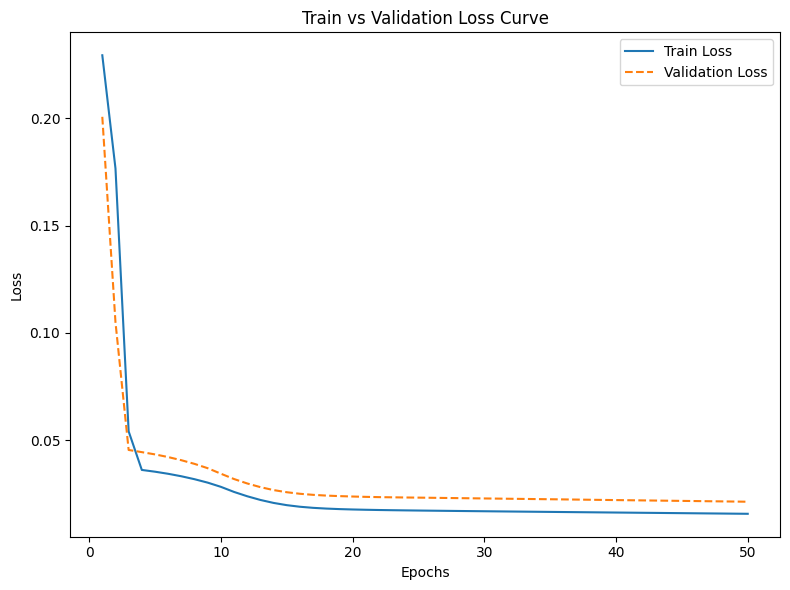

In [13]:
trained_model = train_lstm_model(model, train_loader, val_loader, epochs, learning_rate)

# Test

In [14]:
import numpy as np

In [15]:
def evaluate_test_set(model, test_loader, device):
    model.eval()  # Set model to evaluation mode
    predictions = []
    true_values = []
    
    with torch.no_grad():  # Disable gradient computation for inference
        for X_batch, y_batch in test_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            predictions.append(outputs.cpu().numpy())  # Store predictions
            true_values.append(y_batch.cpu().numpy())  # Store true labels
    
    # Concatenate the results into single arrays
    predictions = np.concatenate(predictions)
    true_values = np.concatenate(true_values)
    
    return predictions, true_values


In [16]:
dataset.mode = 'test'

test_loader = DataLoader(dataset, batch_size=1, shuffle=False)

# check first batch
X_batch, y_batch = next(iter(test_loader))
print("\nSample from test_loader:")
print("X_batch shape:", X_batch.shape)
print("y_batch shape:", y_batch.shape)
print("X_batch:", X_batch)


Sample from test_loader:
X_batch shape: torch.Size([1, 3, 7])
y_batch shape: torch.Size([1, 1])
X_batch: tensor([[[0.0000, 0.0000, 0.2408, 0.0580, 0.0000, 0.3123, 1.0000],
         [0.0000, 0.0000, 0.0774, 0.1976, 0.0000, 0.4061, 0.6364],
         [0.0000, 0.0000, 0.0260, 0.2823, 0.0000, 0.3159, 0.3636]]])


In [17]:
predictions, true_values = evaluate_test_set(trained_model, test_loader, device)

In [18]:
from sklearn.metrics import mean_squared_error, r2_score
rmse = np.sqrt(mean_squared_error(true_values, predictions))
r2 = r2_score(true_values, predictions)

print(f"Test RMSE: {rmse:.4f}")
print(f"Test R²: {r2:.4f}")

Test RMSE: 0.1635
Test R²: 0.5290


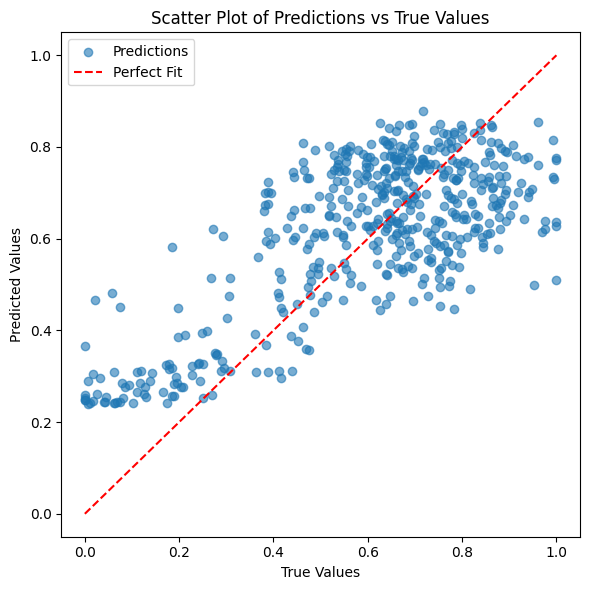

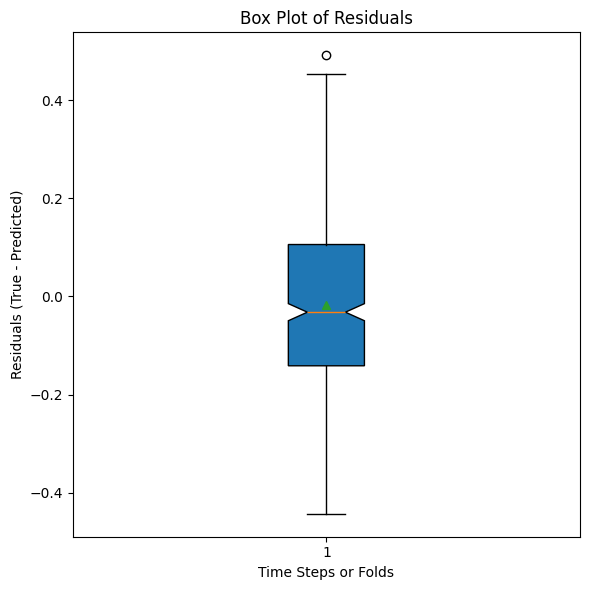

Test RMSE: 0.1635
Test R²: 0.5290


In [19]:
# Convert to numpy arrays for easier handling
true_values = np.array(true_values)
predictions = np.array(predictions)

# Calculate residuals for box plot
residuals = true_values - predictions

# Scatter Plot: True vs. Predicted
plt.figure(figsize=(6, 6))
plt.scatter(true_values, predictions, alpha=0.6, label="Predictions")
plt.plot([min(true_values), max(true_values)], [min(true_values), max(true_values)], 'r--', label="Perfect Fit")
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title("Scatter Plot of Predictions vs True Values")
plt.legend()
plt.tight_layout()
plt.show()

# Box Plot: Residuals
plt.figure(figsize=(6, 6))
plt.boxplot(residuals, notch=True, vert=True, patch_artist=True, showmeans=True)
plt.xlabel("Time Steps or Folds")  # Adjust depending on your dataset
plt.ylabel("Residuals (True - Predicted)")
plt.title("Box Plot of Residuals")
plt.tight_layout()
plt.show()

# Compute metrics
rmse = np.sqrt(mean_squared_error(true_values, predictions))
r2 = r2_score(true_values, predictions)

print(f"Test RMSE: {rmse:.4f}")
print(f"Test R²: {r2:.4f}")